In [1]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.0 MB/s eta 0:00:00


In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [3]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways/"
pages = 20
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews
Scraping page 11
   ---> 1100 total reviews
Scraping page 12
   ---> 1200 total reviews
Scraping page 13
   ---> 1300 total reviews
Scraping page 14
   ---> 1400 total reviews
Scraping page 15
   ---> 1500 total reviews
Scraping page 16
   ---> 1600 total reviews
Scraping page 17
   ---> 1700 total reviews
Scraping page 18
   ---> 1800 total reviews
Scraping page 19
   ---> 1900 total reviews
Scraping page 20
   ---> 2000 total reviews


In [4]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | My family and I have flown ...
1,✅ Trip Verified | This has been by far the wo...
2,✅ Trip Verified | In Nov 2022 I booked and pa...
3,Not Verified | BA is not treating its premium ...
4,✅ Trip Verified | 24 hours before our departu...


In [5]:
df.to_csv("BA_reviews.csv")

In [89]:
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud ,STOPWORDS
import numpy as np
import seaborn as sns
import re
import spacy
import nltk
from nltk import ngrams
from collections import Counter
from nltk.stem.wordnet import WordNetLemmatizer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from spacy.matcher import Matcher

In [16]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Loading data

In [17]:

# Specify the file path
file_path = 'BA_reviews.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Print the DataFrame
print(df)


      Unnamed: 0                                            reviews
0              0  ✅ Trip Verified |  My family and I have flown ...
1              1  ✅ Trip Verified |  This has been by far the wo...
2              2  ✅ Trip Verified |  In Nov 2022 I booked and pa...
3              3  Not Verified | BA is not treating its premium ...
4              4  ✅ Trip Verified |  24 hours before our departu...
...          ...                                                ...
1995        1995  ✅ Verified Review |  Gatwick to Malaga. Aircra...
1996        1996  ✅ Verified Review |  On a flight leaving at 18...
1997        1997  One way, London Heathrow to Amsterdam with Bri...
1998        1998  ✅ Verified Review |  \r\nFlew from London Heat...
1999        1999  ✅ Verified Review |  London Heathrow to Budape...

[2000 rows x 2 columns]


# Data cleaning

In [18]:
def remove_before_pipe(text):
    # Find the index of the first occurrence of "|"
    index = text.find("|")

    # Check if "|" is found in the string
    if index != -1:
        # Extract the substring after "|"
        new_text = text[index+1:].strip()
        return new_text
    else:
        # "|" not found in the string
        return text




In [19]:
# Apply the function to the "reviews" column
df['reviews'] = df['reviews'].apply(remove_before_pipe)

# Print the updated DataFrame
print(df)

      Unnamed: 0                                            reviews
0              0  My family and I have flown mostly on British A...
1              1  This has been by far the worst service I have ...
2              2  In Nov 2022 I booked and paid for a return jou...
3              3  BA is not treating its premium economy passeng...
4              4  24 hours before our departure on BA059 to Cape...
...          ...                                                ...
1995        1995  Gatwick to Malaga. Aircraft on remote stand at...
1996        1996  On a flight leaving at 18:55 the advertised sn...
1997        1997  One way, London Heathrow to Amsterdam with Bri...
1998        1998  Flew from London Heathrow to Seattle. Poor boa...
1999        1999  London Heathrow to Budapest. It seems British ...

[2000 rows x 2 columns]


In [20]:
# Delete rows with null values in "reviews" column
df = df.dropna(subset=["reviews"])

In [21]:
def clean_function(text):
    # Remove special characters and symbols
    cleaned_text = re.sub(r'[^a-zA-Z\s]', ' ', str(text))

    # Remove extra white spaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)

    # Convert to lowercase
    #cleaned_text = cleaned_text.lower()

    # Other cleaning operations specific to your data

    return cleaned_text

In [22]:
df["reviews"] = df["reviews"].apply(lambda x: clean_function(x))

In [23]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenize text into words
    words = nltk.word_tokenize(text)

    # Remove stopwords
    #filtered_words = [word for word in words if word.lower() not in stop_words]

    # Lemmatize words
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    # Join the words back into a single string
    preprocessed_text = ' '.join(lemmatized_words)

    return preprocessed_text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
df["reviews"] = df["reviews"].apply(preprocess_text)

In [25]:
df = df[df["reviews"].str.strip() != '']


In [26]:
df.head(5)

,Unnamed: 0,reviews
0,0,My family and I have flown mostly on British A...
1,1,This ha been by far the worst service I have h...
2,2,In Nov I booked and paid for a return journey ...
3,3,BA is not treating it premium economy passenge...
4,4,hour before our departure on BA to Cape Town f...


# Sentiment analysis

In [27]:
def get_word_count(text):
    words = text.split()
    return len(words)

In [28]:
def limit_word_count(text, max_words):
    words = text.split()
    limited_words = words[:max_words]  # Limit the words to the desired count
    limited_text = ' '.join(limited_words)  # Convert limited words back to text
    return limited_text

In [95]:
def analyze_sentiment(text):
    num = get_word_count(text)  # Get the word count of the input text
    #
    if num > 470:
        text = limit_word_count(text, 470)  # Limit the word count to 470 if it exceeds the maximum limit (model input should be less than 500 words)
    print(num, get_word_count(text))  # Print the original and updated word counts

    # Run sentiment analysis using the Roberta Model
    encoded_text = tokenizer(str(text), return_tensors='pt')  # Tokenize the text using a tokenizer
    output = model(**encoded_text)  # Pass the tokenized text to the sentiment analysis model
    scores = output[0][0].detach().numpy()  # Retrieve the sentiment scores
    scores = softmax(scores)  # Apply softmax function to obtain normalized scores

    scores_dict = {
        'Negative': scores[0],
        'Neutral': scores[1],
        'Positive': scores[2]
    }  # Create a dictionary mapping sentiment labels to their respective scores

    max_key = max(scores_dict, key=lambda k: scores_dict[k])  # Get the sentiment label with the maximum score
    max_value = scores_dict[max_key]  # Get the maximum score value

    if max_key == 'Negative':
        return max_key, -max_value  # Return the sentiment label as negative with a negated score value
    if max_key == 'Neutral':
        if scores_dict["Negative"] < scores_dict["Positive"]:
            return "Positive", scores_dict["Positive"]  # Return the sentiment label as positive with a positive score value
        else:
            return "Negative", -scores_dict["Negative"]  # Return the sentiment label as negative with a negated score value

    return max_key, max_value  # Return the sentiment label with the maximum score


In [ ]:
df[['sentiment analysis', 'Polarity']] = df["reviews"].apply(analyze_sentiment).apply(pd.Series)

304 304
135 135
190 190
37 37
313 313
105 105
61 61
131 131
31 31
48 48
283 283
322 322
114 114
106 106
139 139
317 317
53 53
50 50
186 186
35 35
45 45
98 98
175 175
256 256
78 78
100 100
139 139
346 346
60 60
46 46
122 122
457 450
88 88
143 143
218 218
102 102
101 101
76 76
64 64
46 46
80 80
100 100
441 441
52 52
99 99
424 424
95 95
28 28
156 156
248 248
169 169
131 131
90 90
112 112
108 108
185 185
112 112
311 311
58 58
55 55
118 118
387 387
423 423
97 97
123 123
69 69
87 87
135 135
30 30
169 169
204 204
313 313
196 196
249 249
36 36
97 97
88 88
69 69
101 101
84 84
89 89
97 97
126 126
117 117
137 137
208 208
421 421
210 210
128 128
69 69
85 85
185 185
230 230
209 209
44 44
235 235
52 52
182 182
67 67
116 116
603 450
248 248
60 60
134 134
147 147
619 450
285 285
106 106
285 285
57 57
81 81
109 109
147 147
148 148
59 59
116 116
129 129
34 34
108 108
54 54
43 43
46 46
123 123
111 111
488 450
97 97
53 53
42 42
212 212
309 309
29 29
306 306
71 71
97 97
64 64
23 23
119 119
221 221
102 102


In [32]:
df.head(5)

,Unnamed: 0,reviews,sentiment analysis,Polarity
0,0,My family and I have flown mostly on British A...,Negative,-0.673253
1,1,This ha been by far the worst service I have h...,Negative,-0.947917
2,2,In Nov I booked and paid for a return journey ...,Negative,-0.590295
3,3,BA is not treating it premium economy passenge...,Negative,-0.767230
4,4,hour before our departure on BA to Cape Town f...,Negative,-0.667060


# Sentiment analysis

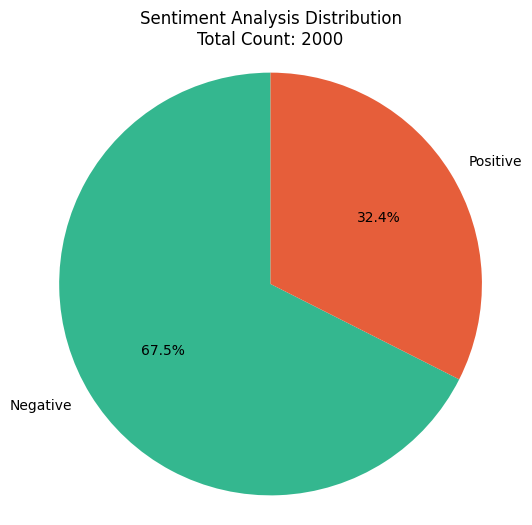

In [36]:
# Count the number of occurrences for each sentiment
sentiment_counts = df['sentiment analysis'].value_counts()

# Create labels and values for the pie chart
labels = sentiment_counts.index
values = sentiment_counts.values

# Calculate the total count of sentiment occurrences
total_count = sum(values)

# Set custom colors for each slice
colors = ['#34b78f', '#e65e3a', '#7d91b4']

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title(f'Sentiment Analysis Distribution\nTotal Count: {total_count}')
plt.axis('equal')

# Display the chart
plt.show()


<ipython-input-41-0668dc733635>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(positive_sentiment['Polarity'], bins=20, kde=True, color='green', label='Positive Sentiment')
<ipython-input-41-0668dc733635>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(negative_sentiment['Polarity'], bins=20,

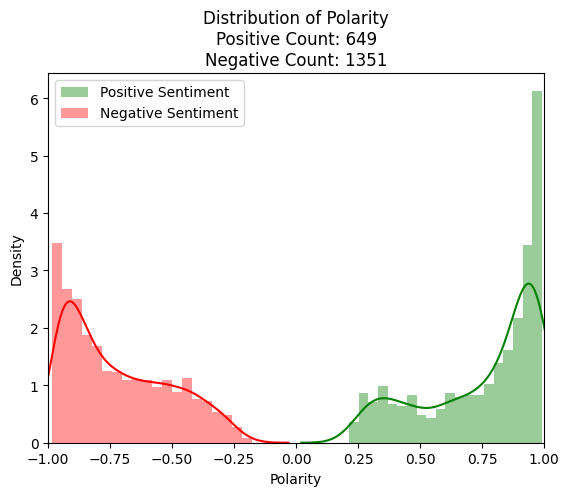

In [41]:

# Create separate dataframes for positive and negative sentiments
positive_sentiment = df[df['sentiment analysis'] == 'Positive']
negative_sentiment = df[df['sentiment analysis'] == 'Negative']

# Create a distribution plot (distplot) for positive sentiment
sns.distplot(positive_sentiment['Polarity'], bins=20, kde=True, color='green', label='Positive Sentiment')

# Create a distribution plot (distplot) for negative sentiment
sns.distplot(negative_sentiment['Polarity'], bins=20, kde=True, color='red', label='Negative Sentiment')

# Set the x-axis limits
plt.xlim(-1, 1)

# Calculate the total count of polarity values for positive and negative sentiments
positive_count = positive_sentiment['Polarity'].count()
negative_count = negative_sentiment['Polarity'].count()

# Set the plot title and labels, including the total count for each sentiment
plt.title(f'Distribution of Polarity\nPositive Count: {positive_count}\nNegative Count: {negative_count}')
plt.xlabel('Polarity')
plt.ylabel('Density')

# Show a legend for the two sentiment categories
plt.legend()

# Show the plot
plt.show()


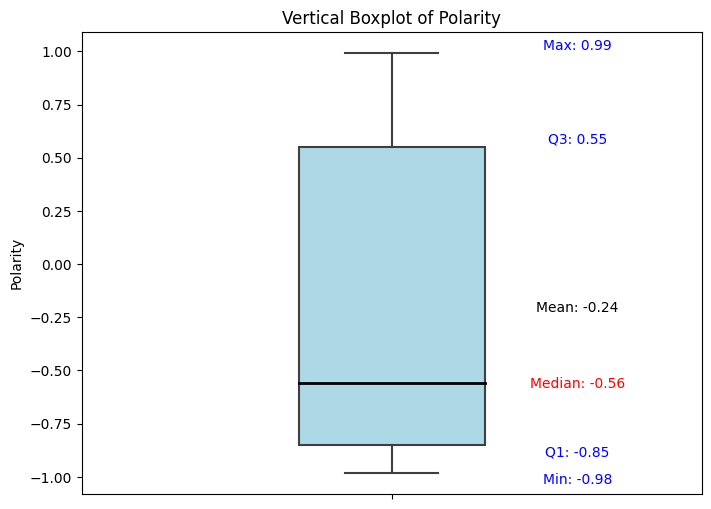

In [59]:
# Set the figure size
plt.figure(figsize=(8, 6))

# Create a vertical boxplot of the 'Polarity' column with adjusted width
sns.boxplot(data=df, y='Polarity', width=0.3, showfliers=True, boxprops=dict(facecolor='lightblue'),
            flierprops=dict(marker='o', markersize=8, markeredgecolor='red', markerfacecolor='red'),
            medianprops=dict(color='black', linewidth=2))

# Calculate statistics
min_val = df['Polarity'].min()
q1 = df['Polarity'].quantile(0.25)
median = df['Polarity'].median()
q3 = df['Polarity'].quantile(0.75)
max_val = df['Polarity'].max()
mean = df['Polarity'].mean()

# Add the statistics values to the plot
plt.text(0.3, min_val, f'Min: {min_val:.2f}', ha='center', va='top', color='blue')
plt.text(0.3, q1, f'Q1: {q1:.2f}', ha='center', va='top', color='blue')
plt.text(0.3, median, f'Median: {median:.2f}', ha='center', va='center', color='red')
plt.text(0.3, q3, f'Q3: {q3:.2f}', ha='center', va='bottom', color='blue')
plt.text(0.3, max_val, f'Max: {max_val:.2f}', ha='center', va='bottom', color='blue')
plt.text(0.3, mean, f'Mean: {mean:.2f}', ha='center', va='bottom', color='black')

# Set the plot title and labels
plt.title('Vertical Boxplot of Polarity')
plt.ylabel('Polarity')

# Show the plot
plt.show()

# WordCloud

In [50]:
# Create stopword list:
stop_words = set(STOPWORDS)

dict_keys(['wa', 'flight', 'BA', 'seat', 'time', 'good', 'food', 'crew', 'service', 'British Airway', 'check', 'London', 'drink', 'one', 'cabin crew', 'staff', 'friendly', 'comfortable', 's', 'London Heathrow', 'great', 'passenger', 'cabin', 'airline', 'experience', 'nice', 'lounge', 'flight wa', 'really', 'aircraft', 'well', 'business class', 'meal', 'economy', 'Heathrow', 'hour', 'made', 'first', 'back', 'new', 'Overall', 'boarding', 'board', 'efficient', 'excellent', 'u', 'plane', 'although', 'still', 'way', 'airport', 'ha', 'offered', 'gate', 'choice', 'bag', 'food wa', 'even', 'best', 'breakfast', 'better', 'much', 'flying', 'professional', 'got', 'LHR', 'fly', 'Gatwick', 'take', 'will', 'arrived', 'wa good', 'little', 'snack', 'service wa', 't', 'day', 'flew', 'wine', 'helpful', 'two', 'due', 'full', 'minute', 'given', 'security', 'return', 'arrival', 'Club World', 'old', 'attentive', 'small', 'landing', 'took', 'IFE', 'free', 'trip', 'premium economy', 'departure', 'bit', 'didn 

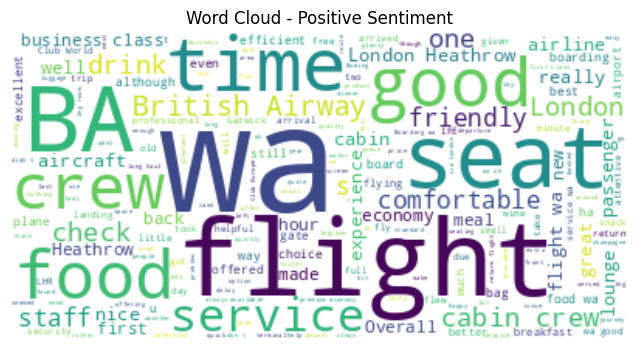

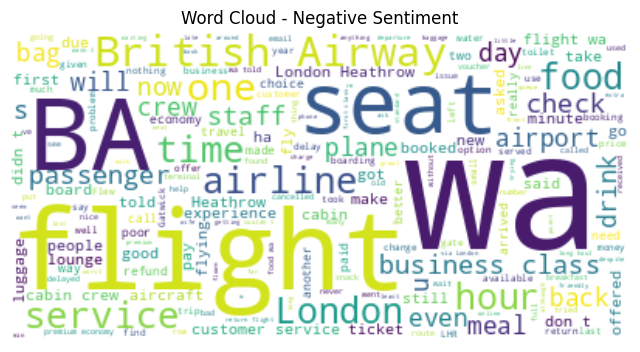

In [116]:


# Filter the dataframe by sentiment category
positive_text = df[df['sentiment analysis'] == 'Positive']["reviews"].str.cat(sep=' ')
negative_text = df[df['sentiment analysis'] == 'Negative']["reviews"].str.cat(sep=' ')

# Create word clouds for positive and negative sentiment
positive_wordcloud = WordCloud(stopwords=stop_words,background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(stopwords=stop_words,background_color='white').generate(negative_text)

print(positive_wordcloud.words_.keys())
print(negative_wordcloud.words_.keys())

# Plot the positive word cloud
plt.figure(figsize=(8, 8))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Positive Sentiment")
plt.show()

# Plot the negative word cloud
plt.figure(figsize=(8, 8))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Negative Sentiment")
plt.show()


### Wordcloud 2 words by 2 Words

In [113]:
def generate_wordcloud(text, title):
    # Convert the text to lowercase
    text = text.lower()

    # Tokenize the text into words
    tokens = nltk.word_tokenize(text)

    # Remove stop words
    #stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Create 2-word phrases
    phrases = list(ngrams(tokens, 2))

    # Count the frequency of 2-word phrases
    frequency = Counter(phrases)

    # Convert tuple keys to strings
    frequency = {' '.join(key): value for key, value in frequency.items()}

    # Generate the word cloud with white background
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies(frequencies=frequency)
    print(wordcloud.words_)

    # Create a figure and axes
    fig, ax = plt.subplots()
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")

    # Add a title to the word cloud
    ax.set_title(f"{title}\n(Two Words by Two Words)")

    # Display the word cloud
    plt.show()

{'british airways': 1.0, 'cabin crew': 0.8744939271255061, 'flight wa': 0.7935222672064778, 'london heathrow': 0.6882591093117408, 'wa good': 0.5748987854251012, 'business class': 0.5546558704453441, 'food wa': 0.42105263157894735, 'service wa': 0.3724696356275304, 'club world': 0.31983805668016196, 'premium economy': 0.29554655870445345, 'didn t': 0.2874493927125506, 'boarding wa': 0.2388663967611336, 'wa ok': 0.2388663967611336, 'long haul': 0.23481781376518218, 'return flight': 0.22267206477732793, 'seat wa': 0.21862348178137653, 'good flight': 0.2145748987854251, 'food drink': 0.21052631578947367, 'club europe': 0.21052631578947367, 'first class': 0.20647773279352227, 'via london': 0.19838056680161945, 'lounge wa': 0.1902834008097166, 'don t': 0.1862348178137652, 'plane wa': 0.1862348178137652, 'hour flight': 0.17813765182186234, 'leg room': 0.17813765182186234, 'first time': 0.17408906882591094, 'flight attendant': 0.17408906882591094, 'wa excellent': 0.1659919028340081, 'ba s': 0

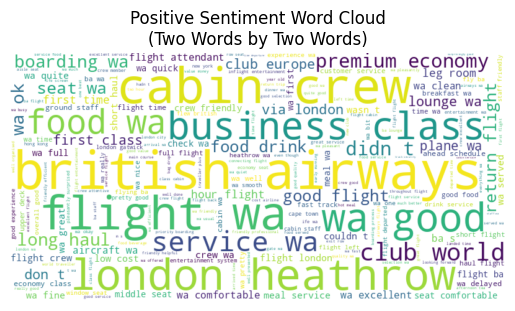

{'british airways': 1.0, 'business class': 0.6217616580310881, 'flight wa': 0.4805699481865285, 'customer service': 0.3795336787564767, 'london heathrow': 0.36139896373056996, 'don t': 0.32512953367875647, 'cabin crew': 0.31994818652849744, 'didn t': 0.27202072538860106, 'wa told': 0.19689119170984457, 'premium economy': 0.19170984455958548, 'food wa': 0.17875647668393782, 'hour flight': 0.16580310880829016, 'couldn t': 0.15414507772020725, 'return flight': 0.1489637305699482, 'via london': 0.14766839378238342, 'wasn t': 0.14248704663212436, 'long haul': 0.13860103626943004, 'service wa': 0.13860103626943004, 'first class': 0.13471502590673576, 'ba s': 0.12953367875647667, 'budget airline': 0.12435233160621761, 'connecting flight': 0.12305699481865284, 'wa delayed': 0.12176165803108809, 'food drink': 0.11528497409326424, 'plane wa': 0.11528497409326424, 'low cost': 0.10621761658031088, 'even though': 0.09844559585492228, 'flight attendant': 0.09844559585492228, 'club world': 0.09326424

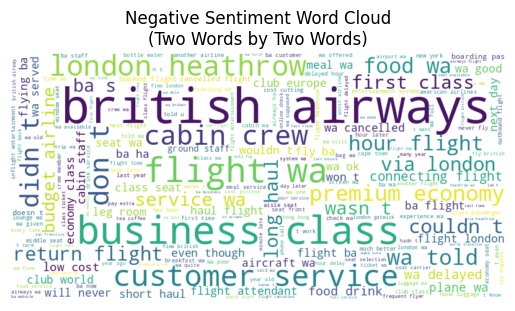

In [114]:
# Filter for positive sentiment
positive_text = ' '.join(df.loc[df['sentiment analysis'] == 'Positive', "reviews"])

# Generate word cloud for positive sentiment
generate_wordcloud(positive_text, title='Positive Sentiment Word Cloud')

# Filter for negative sentiment
negative_text = ' '.join(df.loc[df['sentiment analysis'] == 'Negative', "reviews"])

# Generate word cloud for negative sentiment
generate_wordcloud(negative_text, title='Negative Sentiment Word Cloud')

In [100]:
from wordcloud import WordCloud

def generate_wordcloud(text, title):
    # Generate word cloud
    wordcloud = WordCloud().generate(text)
    wordcloud.recolor(random_state=42)  # Optional: set the color scheme

    # Display or save the word cloud
    # (You can modify this function to suit your display or save preferences)

    return wordcloud

# Filter for positive sentiment
positive_text = ' '.join(df.loc[df['sentiment analysis'] == 'Positive', "reviews"])

# Generate word cloud for positive sentiment
positive_wordcloud = generate_wordcloud(positive_text, title='Positive Sentiment Word Cloud')

# Convert the positive word cloud content to text
positive_wordcloud_text = ' '.join(positive_wordcloud.words_.keys()) if positive_wordcloud else ""

# Display the positive word cloud content in text format
print("Positive Sentiment Word Cloud:")
print(positive_wordcloud_text)
print()

# Filter for negative sentiment
negative_text = ' '.join(df.loc[df['sentiment analysis'] == 'Negative', "reviews"])

# Generate word cloud for negative sentiment
negative_wordcloud = generate_wordcloud(negative_text, title='Negative Sentiment Word Cloud')

# Convert the negative word cloud content to text
negative_wordcloud_text = ' '.join(negative_wordcloud.words_.keys()) if negative_wordcloud else ""

# Display the negative word cloud content in text format
print("Negative Sentiment Word Cloud:")
print(negative_wordcloud_text)


Positive Sentiment Word Cloud:
wa flight BA seat time good food crew service British Airway check London drink one cabin crew staff friendly comfortable s London Heathrow great passenger cabin airline experience nice lounge flight wa really aircraft well business class meal economy Heathrow hour made first back new Overall boarding board efficient excellent u plane although still way airport ha offered gate choice bag food wa even best breakfast better much flying professional got LHR fly Gatwick take will arrived wa good little snack service wa t day flew wine helpful two due full minute given security return arrival Club World old attentive small landing took IFE free trip premium economy departure bit didn t delay use served standard thank used make business quite terminal always now decent pleasant journey quality luggage usual quick long leg option need water long haul extra available product Boarding wa issue enough lot though pay ok clean people selection price route happy seeme

In [150]:
def calculate_word_frequency(text, wordcloud):
    # Tokenize the text into individual words
    words = text.lower().split()

    # Calculate the frequency of each word in the text
    word_frequency = Counter(words)

    # Tokenize the text into word pairs
    word_pairs = re.findall(r'\b\w+\s\w+\b', text.lower())

    # Calculate the frequency of each word pair in the text
    word_pair_frequency = Counter(word_pairs)

    # Get the words from the word cloud as a set
    wordcloud_words = set(wordcloud.words_.keys())

    # Create a dictionary to store the merged frequencies
    wordcloud_freq = {}

    # Iterate over the words and word pairs from the word cloud
    for word in wordcloud_words:
        # Check if the word is present in word_frequency
        if word in word_frequency:
            wordcloud_freq[word] = word_frequency[word]
        # Check if the word pair is present in word_pair_frequency
        elif word in word_pair_frequency:
            wordcloud_freq[word] = word_pair_frequency[word]

    return wordcloud_freq

In [151]:
# Calculate positive text word frequency from word cloud
positive_wordcloud_freq = calculate_word_frequency(positive_text, positive_wordcloud)

# Calculate negative text word frequency from word cloud
negative_wordcloud_freq = calculate_word_frequency(negative_text, negative_wordcloud)

# Display the frequency of the words and word pairs from positive_wordcloud in positive text
print("Positive Text Word Frequency from Word Cloud:")
for word, freq in positive_wordcloud_freq.items():
    print(f"{word}: {freq}")

# Display the frequency of the words and word pairs from negative_wordcloud in negative text
print("Negative Text Word Frequency from Word Cloud:")
for word, freq in negative_wordcloud_freq.items():
    print(f"{word}: {freq}")

Positive Text Word Frequency from Word Cloud:
free: 76
way: 117
well: 212
rather: 53
quickly: 50
screen: 74
experience: 194
good: 589
leg room: 23
meal: 205
bag: 121
breakfast: 115
tasty: 46
wa: 2524
attentive: 78
help: 43
say: 43
full: 118
business class: 62
used: 71
found: 45
choice: 105
plane: 156
water: 58
first class: 24
offered: 106
fly: 109
go: 50
seat: 628
drink: 254
aircraft: 185
made: 137
economy: 241
excellent: 151
didn t: 37
thing: 51
issue: 56
really: 168
back: 147
wa good: 47
hour: 207
s: 242
efficient: 116
decent: 63
thank: 45
journey: 74
snack: 86
use: 68
old: 103
felt: 45
seating: 53
staff: 242
still: 111
pay: 55
selection: 75
last: 74
one: 217
two: 94
seemed: 53
cabin crew: 113
airline: 177
flight: 1350
ha: 107
crew: 553
leg: 121
late: 72
row: 83
food wa: 55
t: 366
small: 77
pleasant: 79
home: 50
standard: 67
though: 72
route: 58
product: 64
bad: 43
quality: 87
fine: 85
day: 93
premium economy: 30
will: 93
need: 59
long haul: 33
legroom: 54
boarding: 235
cabin: 415
tr

In [155]:

def plot_top_words(wordcloud_freq, sentiment):
    # Sort the wordcloud_freq dictionary by frequency in descending order
    sorted_freq = sorted(wordcloud_freq.items(), key=lambda x: x[1], reverse=True)

    # Extract the top 10 words or word pairs and their frequencies
    top_10 = sorted_freq[:10]
    top_words = [word for word, freq in top_10]
    top_freq = [freq for word, freq in top_10]

    # Create a bar plot of the top 10 words or word pairs
    plt.bar(top_words, top_freq)
    plt.xlabel('Words or Word Pairs')
    plt.ylabel('Frequency')
    plt.title(f'Top 10 Words or Word Pairs in {sentiment} Text')
    plt.xticks(rotation=45)

    # Display the bar plot
    plt.show()



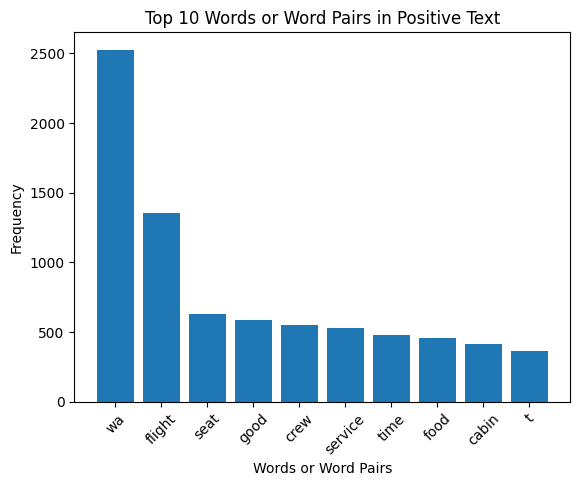

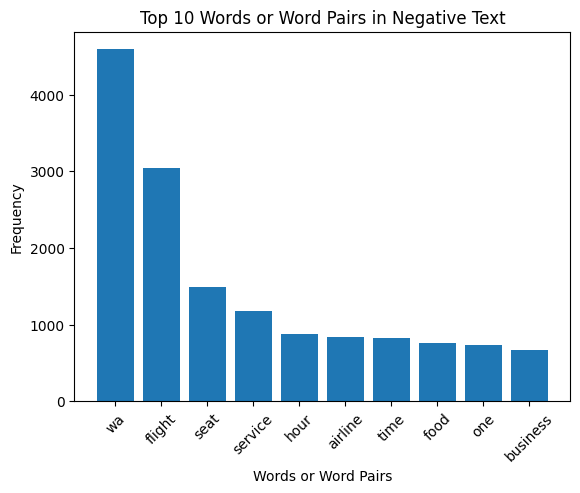

In [156]:

# Plot the top words or word pairs for positive text
plot_top_words(positive_wordcloud_freq, 'Positive')

# Plot the top words or word pairs for negative text
plot_top_words(negative_wordcloud_freq, 'Negative')


# Text analysis with Spacy

In [62]:
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 1850000

In [63]:
df["reviews"] = df["reviews"].astype(str)

In [69]:
all_text = df["reviews"].str.cat(sep = '. ')

In [74]:
# Apply spaCy NLP pipeline to process the 'all_text' string, disabling Named Entity Recognition (NER)
doc = nlp(all_text, disable=['ner'])

In [75]:
# Extract lemmas for each token in 'doc' excluding stop words and punctuation
words = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

# Count the frequency of each word
word_freq = Counter(words)

# Retrieve the 20 most common words and their frequencies
most_common_words = word_freq.most_common(20)


In [80]:
# Create a Matcher object using the spaCy vocabulary
matcher = Matcher(nlp.vocab)

# Define a pattern for adjective-noun phrases
pattern = [{'POS': 'ADJ'}, {'POS': 'NOUN'}]

# Add the pattern to the matcher
matcher.add('ADJ_PHRASE', [pattern])

# Find matches in the 'doc' and return them as spans
matches = matcher(doc, as_spans=True)

# Extract the matched phrases and convert them to lowercase
phrases = []
for span in matches:
    phrases.append(span.text.lower())

    # Count the frequency of each phrase
    phrase_freq = Counter(phrases)

# Retrieve the 30 most common phrases and their frequencies
most_common_phrases = phrase_freq.most_common(30)


In [83]:
print (most_common_phrases,)

[('long haul', 157), ('other airline', 125), ('low cost', 115), ('premium economy', 96), ('first class', 95), ('short haul', 94), ('first time', 81), ('middle seat', 71), ('next day', 65), ('other passenger', 48), ('inflight entertainment', 46), ('good flight', 45), ('fast track', 44), ('last year', 39), ('next flight', 39), ('full flight', 37), ('outbound flight', 37), ('upper deck', 37), ('main course', 37), ('short flight', 35), ('online check', 33), ('frequent flyer', 33), ('long time', 33), ('first flight', 31), ('many year', 31), ('last minute', 30), ('last time', 30), ('good experience', 30), ('british airway', 29), ('full service', 27)]


#### Searching for sentences that express feelings

In [84]:
# Create an empty list to store adjective tokens related to feelings
feel_adj = []

# Create a Matcher object using the spaCy vocabulary
matcher = Matcher(nlp.vocab)

# Define a pattern to match adjective tokens related to feelings
pattern = [{'LOWER': {'IN': ['i', 'we']}}, {'OP': '?'},
           {'LOWER': {'IN': ['feel', 'am', "'m", 'are', "'re"]}},
           {'OP': '?'}, {'OP': '?'}, {'POS': 'ADJ'}]

# Add the pattern to the matcher
matcher.add("FeelAdj", [pattern])

# Find matches in the 'doc' and return them as spans
matches = matcher(doc, as_spans=True)

# Extract the lemma of each adjective token in the matches and store them in 'feel_adj'
for span in matches:
    feel_adj.extend([token.lemma_ for token in span if token.pos_ == 'ADJ'])

# Count the frequency of each adjective lemma
adj_freq = Counter(feel_adj)

# Retrieve the 20 most common adjective lemmas and their frequencies
most_common_adj = adj_freq.most_common(20)


In [85]:
print(most_common_adj)

[('tall', 11), ('sure', 10), ('happy', 9), ('disappointed', 8), ('sorry', 7), ('frequent', 7), ('unable', 5), ('aware', 4), ('frustrated', 4), ('sad', 4), ('impressed', 3), ('grateful', 3), ('old', 3), ('more', 3), ('sick', 3), ('due', 3), ('afraid', 2), ('thankful', 2), ('silver', 2), ('upset', 2)]


In [86]:
#Cg : give me 3 most positive comments
#Cg : give me 3 most negative comments
# Extract  most positive and negative comment

# Create a Matcher object using the spaCy vocabulary
matcher = Matcher(nlp.vocab)

# Define a pattern to match sentences containing adjectives or adverbs related to feelings
pattern = [
    {"LOWER": {"IN": ["i", "we"]}},        # Match "I" or "we" in lowercase
    {"OP": "?"},                          # Optional token
    {"LOWER": {"IN": ["feel", "am", "'m", "are", "'re"]}},    # Match common feel-related words
    {"OP": "?"},                          # Optional token
    {"OP": "?"},                          # Optional token
    {"OP": "?"},                          # Optional token
    {"POS": {"IN": ["ADJ", "ADV"]}, "OP": "*"},    # Match zero or more adjectives or adverbs
]

# Add the pattern to the matcher
matcher.add("FeelSentence", [pattern])

# Find matches in the 'doc' and return them as spans
matches = matcher(doc, as_spans=True)

# Create a set to store unique feel-related sentences
feel_sentences = set()

# Iterate over the matches and extract the sentence text
for match in matches:
    sentence = match.sent
    feel_sentences.add(sentence.text)

# Convert the set to a list
feel_sentences = list(feel_sentences)

# Print the list of unique feel-related sentences
feel_sentences


['BA used to be my go to carrier and I am a silver member',
 'I am one of those crazy people who still until recently flew Edinburgh London Heathrow weekly paying nearly with British Airways a it s the key airport Now the last flight always come to a remote stand and the morning flight boarding for flight is onto a bus to a plane that is never ready and always departs late Holidays in Madeira ended with me and mum sitting on the floor in a departure hall for hr I wrote to BA and got the big fob off Add insult to injury and no food at all on the plane',
 'The alternative is BA s Business Class Club World and that is an industry joke with the ying yang seat Off to Perth in the Spring and flying First Guess who we are not flying with.',
 'London Heathrow to Johannesburg return Outward leg wa full Seat downstairs on the aisle I am tall and there is not much leg room Plane wa clean and crew efficient Evening meal of chicken and rice wa passable Departed and landed on time I wa actually en r

#### Extracting Phrases Indicating Wants and Needs

In [87]:
# Create an empty list to store adjective tokens related to wants or needs
want_adj = []

# Create a Matcher object using the spaCy vocabulary
matcher = Matcher(nlp.vocab)

# Define patterns to match phrases indicating wants or needs
pattern = [
    {'LOWER': {'IN': ['i', 'we', 'you', 'they', 'he']}},
    {'IS_ALPHA': True, 'OP': '?'},
    {'LOWER': {'IN': ['need', 'want', 'wants', 'must', 'improve', 'improves', 'should']}},
    {'IS_ALPHA': True, 'OP': '?'},
    {'IS_ALPHA': True, 'OP': '?'},
    {'POS': 'NOUN'}
]

pattern2 = [
    {'LOWER': 'i'},
    {'LOWER': 'want'},
    {'LOWER': 'to'},
    {'LOWER': 'improve'},
    {'LOWER': 'my'},
    {'LOWER': 'skills'}
]

# Add the patterns to the matcher
matcher.add("WantPhrase", [pattern, pattern2])

# Find matches in the 'doc' and return them as spans
matches = matcher(doc, as_spans=True)

# Iterate over the matches and print each match
for match in matches:
    print(match, "\n")


you need a proof 

you need to do screenshots 

you just want short term 

I must travel today 

I need shoe 

I need shoe toiletry 

I need shoe toiletry clothes 

You should have a button 

they need to employ people 

I want a refund 

you should take the opportunity 

they should check overhead locker 

I need any help 

I must state staff 

you should prioritize service 

you need help 

they want an extra 

you want a snack 

you need anything between meal 

they want to keep people 

I need special assistance 

I should have had priority 

we should lose our leg 

you want The seat 

I must make my way 

I now need to purchase food 

I want at this point 

they want for a can 

they should refund the money 

I need a G 

I need a G T 

You must downgrade your rating 

you want good service 

they should pay the excess 

I want a budget 

I want a budget flight 

I could need Also the price 

I d need some assurance 

we should have flown economy 

you should get a meal 

they sh

In [90]:
# Create a list to store the "want" adjectives
want_adj = []

# Create a matcher object
matcher = Matcher(nlp.vocab)

# Create a pattern that matches the following:
# - A word that is "i" or "we"
# - An optional word
# - A word that is "need" or "want"
# - An optional word
# - An optional word
# - A noun
pattern = [{'LOWER': {'IN': ['i', 'we']}}, {'IS_ALPHA': True, 'OP': '?'},
            {'LOWER': {'IN': ['need', 'want']}},
            {'IS_ALPHA': True, 'OP': '?'}, {'IS_ALPHA': True, 'OP': '?'}, {'POS': 'NOUN'}]

# Add the pattern to the matcher
matcher.add("WantPhrase", [pattern])

# Match the pattern against the document
matches = matcher(doc, as_spans=True)

# Create a list to store the sentences that contain the "want" adjectives
sentences = []

# Iterate over the matches and add the sentences to the list
with tqdm.tqdm(total=len(matches), desc="Processing matches") as pbar:
    for m in matches:
        sentence = m.sent
        sentences.append(sentence.text)
        pbar.update(1)

# Print the sentences
for sentence in sentences:
    print(sentence)


Processing matches: 100%|██████████| 15/15 [00:00<00:00, 5872.18it/s]

this wa day ago and we still don t have the suitcase or any information about it Today I travelled from Amsterdam to London City Airport again they didn t allow me to board with my cabin suitcase and when I arrived in London the suitcase wa missing left in Amsterdam Suitcases different flight they ve ruined my holiday No compensation no date on when will I get my property back no information lie and more lie I wa told I could complain online and buy all the thing I need shoe toiletry clothes and I might receive the money back in day
this wa day ago and we still don t have the suitcase or any information about it Today I travelled from Amsterdam to London City Airport again they didn t allow me to board with my cabin suitcase and when I arrived in London the suitcase wa missing left in Amsterdam Suitcases different flight they ve ruined my holiday No compensation no date on when will I get my property back no information lie and more lie I wa told I could complain online and buy all the

In [92]:
# Define the patterns for extracting needs
# The patterns are a list of lists, where each inner list represents a single pattern.
# The first element in each inner list is a dictionary that specifies the words or phrases that should be matched.
# The second element in each inner list is a list of POS tags that the matched words or phrases should have.
patterns = [
    [{"LOWER": {"IN": ["need", "require", "seek", "want", "must", "improve", "should"]}}, {}],
    [{"LOWER": {"IN": ["want", "wants", "must", "improve", "improves", "should"]}}, {"LOWER": {"IN": ["more", "additional"]}}, {"POS": "NOUN", "OP": "+"}],
    [{"LOWER": {"IN": [ "people", "individuals"]}}, {"LEMMA": {"IN": ["want", "wants", "must", "improve", "improves", "should"]}}, {"LOWER": {"IN": ["more", "additional"]}}, {"POS": "NOUN", "OP": "+"}],
    [{"LOWER": {"IN": ["i", "we"]}}, {"LEMMA": {"IN": ["want", "wants", "must", "improve", "improves", "should"]}}, {}],
    [{"LEMMA": {"IN": ["seek", "look", "search"]}}, {"LOWER": {"IN": ["guidance", "advice"]}}, {"LOWER": "for"}],
    [{"LOWER": {"IN": ["look", "search"]}}, {"LOWER": {"IN": ["for", "to"]}}, {"POS": "NOUN", "OP": "+"}],
    [{"LOWER": {"IN": ["people", "individuals"]}}, {"LEMMA": {"IN": ["look", "search"]}}, {"LOWER": {"IN": ["for", "to"]}}, {"POS": "NOUN", "OP": "+"}],
]

# Initialize the Matcher
matcher = Matcher(nlp.vocab)

# Add the patterns to the Matcher
for pattern in patterns:
    matcher.add("CUSTEMRS_NEEDS", [pattern])

# Initialize a list to store the extracted needs
extracted_needs = []

# Iterate over the sentences in the document
for sentence in doc.sents:
    # Apply the Matcher to the sentence
    matches = matcher(sentence)

    # Check if any matches are found
    if matches:
        extracted_needs.append(sentence.text)

# Print the extracted needs
for need in extracted_needs:
    print(need)


She said we should try again at the departure gate but that also failed We spoke to a member of the flight crew who wa totally unsympathetic
but on the long Cairo London route they spend most of their time on a break where they use the back row or two and talk loudly without any consideration for the passenger And for the flyer who don t want the hassle of charge minimal cabin service and budget seat then they could easily provide a premium economy option and really make a difference for the experience Heathrow Terminal compound the poor experience especially for arrival It is also poorly served by transport link especially for those of u who live near Gatwick which is being abandoned by BA I have been a frequent flyer for many year and wa even a BA Gold Card holder at one point
But on my flight there wa none because of supply issue The cabin attendant I think his name wa Tom must be one of the best in the business
It wa the next day I didn t want the flight a wa staying at Docklands h

In [93]:
len(extracted_needs)

661

# Save data as xlsx files

In [94]:
# save all data
df.to_excel('df_BA_reviews.xlsx', index=False)